## Importing the relevant packages


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts 
import seaborn as sns
sns.set()

## Importing the Data and Pre-processing 

In [23]:
raw_csv_data = pd.read_csv("Index2018.csv") 
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

In [24]:
df_comp['market_value']=df_comp.ftse

In [25]:
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## LLR Test

In [26]:
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

We saw that **S&P** prices resemble a **Random-Walk** but we never teste whether **FTSE** ones do as well. We can do this by calling the augmented **Dickey-Fuller test**.

## The DF-Test

In [27]:
sts.adfuller(df.market_value)

(-1.9041551418836884,
 0.3301089327702823,
 6,
 5014,
 {'1%': -3.4316548765428174,
  '5%': -2.8621166146845334,
  '10%': -2.5670769326348926},
 54854.15304507557)

We see that $p-value = 0.33$, so we can't conclusevely say the data comes from a stationary process, that's why we can assume it is extracted from a **non-stationary** process. This suggetsts we shouldm't rely on **AR** models to make accurate forecasts. 

We'll trnasforming the data set, so that it fits the **stationary** assumptions. In finance, the common approach is to use returns instead of prices.

## Using Returns

**returns** expresses the percentage changes between the values for two consecutive periods

$$
returns = \frac{P_{t}-P_{t-1}}{P_{t-1}}* 100
$$

- $r>0$ (positive returns): Indicate an increase in the prices.
- $r<0$ (negative returns): Indicate a decline.



In [28]:
df['returns'] = df.market_value.pct_change(1).mul(100)
# change() = Disntace in time between the periods we want to compare.
# mul() = multiplies the entire time-series by a factor
df = df.iloc[1:]
# Theres in one return value fewer than the prices because 1st day does not
# have previous day to compare.
# Ommite the first period by iloc.

C:\Users\Usuario\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [29]:
sts.adfuller(df.returns)

(-12.770265719497234,
 7.79805833603833e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 15696.7672456975)

**The statistic ($-12.77$) is less than even for $1\%$ critical ($-3.43$) value. The data comes from a statonary process.**

## ACF and PACF for Returns

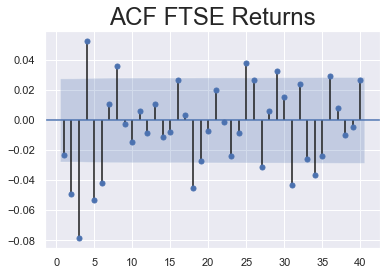

In [30]:
sgt.plot_acf(df.returns, lags=40, zero = False)
plt.title("ACF FTSE Returns", size=24)
plt.show()

Seeing the first 7 values, that suggests that returns over the entire week are relevant to those of the current one since the relationship is negative.

The negative relationship between past and current values suggests that the data wants to avoid falling in a big trend (e.g avoids clustering).

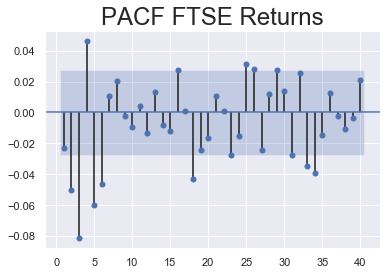

In [31]:
sgt.plot_pacf(df.returns, lags = 40, zero = False, method = ('ols'))
plt.title("PACF FTSE Returns", size=24)
plt.show()

We interpret **PACF** graph that 5 of the frist 6 coefficients are significant, and 4 of them are negative, which suggests the market is tryng to adjust.

## AR(1) for Returns

In [32]:
model_ret_ar_1 = ARMA(df.returns, order = (1,0))

In [33]:
results_ret_ar_1 = model_ret_ar_1.fit()

In [34]:
results_ret_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(1, 0)   Log Likelihood               -7929.749
Method:                       css-mle   S.D. of innovations              1.174
Date:                Sat, 01 Aug 2020   AIC                          15865.497
Time:                        18:12:44   BIC                          15885.061
Sample:                    01-10-1994   HQIC                         15872.353
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.016      1.159      0.247      -0.013       0.051
ar.L1.returns    -0.0230      0.014     -1.631      0.103      -0.051       0.005
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -43.4387           +0.0000j           43.4387            0.5000
-----------------------------------------------------------------------------
"""

$p-values$ of both parameters are over $0.5$, this means that neither is significantly different from zero. Therefore, the model holds no real predictive power because our predictions would always be zero.

This can be explained by the impact past values can have on yesterday's prices: **The more easily yesterday's price is affected by higher lags, the more inaccurate its coefficient becomes.**

This directly decreases the predictive power of the model, so we should proceed by testing whether a higher mlag models serves as a better predictor.

## Higher-Lag AR Models for Returns

In [35]:
model_ret_ar_2 = ARMA(df.returns, order = (2,0))
results_ret_ar_2 = model_ret_ar_2.fit()
results_ret_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(2, 0)   Log Likelihood               -7923.456
Method:                       css-mle   S.D. of innovations              1.173
Date:                Sat, 01 Aug 2020   AIC                          15854.911
Time:                        18:12:44   BIC                          15880.996
Sample:                    01-10-1994   HQIC                         15864.052
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.015      1.220      0.222      -0.011       0.049
ar.L1.returns    -0.0242      0.014     -1.716      0.086      -0.052       0.003
ar.L2.returns    -0.0500      0.014     -3.550      0.000      -0.078      -0.022
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.2417           -4.4635j            4.4701           -0.2586
AR.2           -0.2417           +4.4635j            4.4701            0.2586
-----------------------------------------------------------------------------
"""

In [36]:
LLR_test(model_ret_ar_1, model_ret_ar_2)

0.0

We can see immediatly that the $p-value$ fro the second lag is zero and less than $1\%$ percent, so $\varphi_{2}$ is significantly diferent from zero and should be included in the model, also supports that the model **AR(2)** is a better fit than **AR(1)**; also the $p-value$ for the first has decreased further, since the $p-value$ for the new coefficient is zero, we suspect that the change in **Log-Likelihood** is also significant; we can notice that all **C's**  or **Information Criteria** are lower.

In [37]:
model_ret_ar_3 = ARMA(df.returns, order = (3,0))
results_ret_ar_3 = model_ret_ar_3.fit()
results_ret_ar_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(3, 0)   Log Likelihood               -7906.738
Method:                       css-mle   S.D. of innovations              1.169
Date:                Sat, 01 Aug 2020   AIC                          15823.477
Time:                        18:12:50   BIC                          15856.083
Sample:                    01-10-1994   HQIC                         15834.902
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.330      0.184      -0.009       0.047
ar.L1.returns    -0.0283      0.014     -2.011      0.044      -0.056      -0.001
ar.L2.returns    -0.0521      0.014     -3.705      0.000      -0.080      -0.025
ar.L3.returns    -0.0815      0.014     -5.792      0.000      -0.109      -0.054
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9233           -2.0210j            2.2219           -0.1818
AR.2            0.9233           +2.0210j            2.2219            0.1818
AR.3           -2.4855           -0.0000j            2.4855           -0.5000
-----------------------------------------------------------------------------
"""

In [38]:
LLR_test(model_ret_ar_2, model_ret_ar_3)

0.0

Same conclussions.

In [39]:
model_ret_ar_4 = ARMA(df.returns, order = (4,0))
results_ret_ar_4 = model_ret_ar_4.fit()
print(results_ret_ar_4.summary())
print ("LLR test: " + str(LLR_test(model_ret_ar_3, model_ret_ar_4)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(4, 0)   Log Likelihood               -7901.330
Method:                       css-mle   S.D. of innovations              1.168
Date:                Sat, 01 Aug 2020   AIC                          15814.661
Time:                        18:12:52   BIC                          15853.788
Sample:                    01-10-1994   HQIC                         15828.371
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.015      1.267      0.205      -0.010       0.048
ar.L1.returns    -0.0245      0.014     -1.739      0.082      -0.052       0.003
ar.L2.returns    -0.0496      0.014     

In [40]:
model_ret_ar_5 = ARMA(df.returns, order = (5,0))
results_ret_ar_5 = model_ret_ar_5.fit()
print(results_ret_ar_5.summary())
print ("LLR test: " + str(LLR_test(model_ret_ar_4, model_ret_ar_5)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(5, 0)   Log Likelihood               -7892.390
Method:                       css-mle   S.D. of innovations              1.166
Date:                Sat, 01 Aug 2020   AIC                          15798.779
Time:                        18:12:53   BIC                          15844.428
Sample:                    01-10-1994   HQIC                         15814.775
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.348      0.178      -0.009       0.046
ar.L1.returns    -0.0217      0.014     -1.544      0.123      -0.049       0.006
ar.L2.returns    -0.0544      0.014     

In [41]:
model_ret_ar_6 = ARMA(df.returns, order = (6,0))
results_ret_ar_6 = model_ret_ar_6.fit()
print(results_ret_ar_6.summary())
print ("LLR test: " + str(LLR_test(model_ret_ar_5, model_ret_ar_6)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(6, 0)   Log Likelihood               -7886.945
Method:                       css-mle   S.D. of innovations              1.164
Date:                Sat, 01 Aug 2020   AIC                          15789.890
Time:                        18:12:54   BIC                          15842.059
Sample:                    01-10-1994   HQIC                         15808.170
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.414      0.157      -0.007       0.045
ar.L1.returns    -0.0245      0.014     -1.740      0.082      -0.052       0.003
ar.L2.returns    -0.0523      0.014     

In [42]:
model_ret_ar_7 = ARMA(df.returns, order = (7,0))
results_ret_ar_7 = model_ret_ar_7.fit()
results_ret_ar_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(7, 0)   Log Likelihood               -7886.647
Method:                       css-mle   S.D. of innovations              1.164
Date:                Sat, 01 Aug 2020   AIC                          15791.294
Time:                        18:12:56   BIC                          15849.985
Sample:                    01-10-1994   HQIC                         15811.860
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.399      0.162      -0.008       0.045
ar.L1.returns    -0.0240      0.014     -1.702      0.089      -0.052       0.004
ar.L2.returns    -0.0517      0.014     -3.663      0.000      -0.079      -0.024
ar.L3.returns    -0.0874      0.014     -6.202      0.000      -0.115      -0.060
ar.L4.returns     0.0433      0.014      3.064      0.002       0.016       0.071
ar.L5.returns    -0.0601      0.014     -4.263      0.000      -0.088      -0.032
ar.L6.returns    -0.0463      0.014     -3.282      0.001      -0.074      -0.019
ar.L7.returns     0.0109      0.014      0.772      0.440      -0.017       0.039
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.6490           -0.5384j            1.7347           -0.4498
AR.2           -1.6490           +0.5384j            1.7347            0.4498
AR.3           -0.1189           -1.4954j            1.5001           -0.2626
AR.4           -0.1189           +1.4954j            1.5001            0.2626
AR.5            1.2790           -0.9786j            1.6105           -0.1039
AR.6            1.2790           +0.9786j            1.6105            0.1039
AR.7            5.2269           -0.0000j            5.2269           -0.0000
-----------------------------------------------------------------------------
"""

In [43]:
print (LLR_test(model_ret_ar_6, model_ret_ar_7))

0.44


Since **AR(7)** fails on every aspect when comparing it with **AR(6)**:

- **The additional coefficient is insignificant.**
- **The LLR test fails.**
- **Higher AIC and BIC values.**

We opt for the simple model **AR(6)**.

## Normalizing Values

In the case of Time series, when we normalize a set of values, we basically map every value of the sample space to the percentage of the first value of the set.

$$
\begin{array}{lcr}
x_t & \% \, of \, x_{1} \\
y_t & \% \, of \, y_{1}
\end{array}
$$

In general by normalizing two time series we can compare how well they perform relative to one another. This gives us a better understanding of which ones to invest in and which ones to avoid.

Take a look on the following 

$$
\begin{array}{lcr}
\mbox{S&P}  & \Delta x_{t} = \$ 100 & \Delta Norm \, x_{t} \\
\mbox{NIKKEI} & \Delta y_{t} = \$ 100 & \Delta Norm \, y_{t}
\end{array}
$$

For instance a flat increase of $\Delta x_{t} = \$ 100$ in the price of the **S&P** will be mucho more significant change than the same absolute increase in the price of the Nikkei since Nikkei prices are usually several times higher. However, an increase in the price for **S&P** equivalent to $\%5$ of the original value ($\Delta Norm \, x_{t}$) is comparable to the same percentage increase for the Nikkei ($\Delta Norm \, y_{t}$).

In [44]:
benchmark = df.market_value.iloc[0]

In [45]:
df['norm'] = df.market_value.div(benchmark).mul(100)

In [46]:
sts.adfuller(df.norm)

(-1.8928710132672324,
 0.3354222074330083,
 6,
 5013,
 {'1%': -3.431655136974821,
  '5%': -2.8621167297421373,
  '10%': -2.567076993884522},
 19553.90073102193)

We can see that the test yields a high $p-value$ which suggests **non-stationary**, thus normalizing prices did not result in **stationary** data.

To avoid any biased comparison when analyzing the two sets we often rely on normalized returns:

- They account for the absolute profitability of the investment.
- They allow us to compare the relative profitability as opposed to non normalized returns.

In [47]:
bench_ret = df.returns.iloc[0]
df['norm_ret'] = df.returns.div(bench_ret).mul(100)
sts.adfuller(df.norm_ret)

(-12.7702657194973,
 7.798058336035981e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 80114.49116124898)

We can say with great certainty that this data is stationary. Furthermore, we can conclude that normalizing does not affect stationary

## Normalized Returns

In [48]:
model_norm_ret_ar_1 = ARMA (df.norm_ret, order=(1,0))
results_norm_ret_ar_1 = model_norm_ret_ar_1.fit()
results_norm_ret_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 5020
Model:                     ARMA(1, 0)   Log Likelihood              -40351.743
Method:                       css-mle   S.D. of innovations            749.388
Date:                Sat, 01 Aug 2020   AIC                          80709.487
Time:                        18:13:45   BIC                          80729.050
Sample:                    01-10-1994   HQIC                         80716.342
                         - 04-05-2013                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -11.9731     10.339     -1.158      0.247     -32.237       8.291
ar.L1.norm_ret    -0.0230      0.014     -1.631      0.103      -0.051       0.005
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -43.4387           +0.0000j           43.4387            0.5000
-----------------------------------------------------------------------------
"""

In [49]:
model_norm_ret_ar_2 = ARMA(df.norm_ret, order=(2,0))
results_norm_ret_ar_2 = model_norm_ret_ar_2.fit()
results_norm_ret_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 5020
Model:                     ARMA(2, 0)   Log Likelihood              -40345.450
Method:                       css-mle   S.D. of innovations            748.449
Date:                Sat, 01 Aug 2020   AIC                          80698.901
Time:                        18:13:46   BIC                          80724.985
Sample:                    01-10-1994   HQIC                         80708.041
                         - 04-05-2013                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -11.9731      9.834     -1.218      0.223     -31.247       7.301
ar.L1.norm_ret    -0.0242      0.014     -1.716      0.086      -0.052       0.003
ar.L2.norm_ret    -0.0500      0.014     -3.550      0.000      -0.078      -0.022
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.2417           -4.4635j            4.4701           -0.2586
AR.2           -0.2417           +4.4635j            4.4701            0.2586
-----------------------------------------------------------------------------
"""

In [50]:
model_norm_ret_ar_7 = ARMA(df.norm_ret, order=(7,0))
results_norm_ret_ar_7 = model_norm_ret_ar_7.fit()
results_norm_ret_ar_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 5020
Model:                     ARMA(7, 0)   Log Likelihood              -40308.642
Method:                       css-mle   S.D. of innovations            742.977
Date:                Sat, 01 Aug 2020   AIC                          80635.283
Time:                        18:13:46   BIC                          80693.974
Sample:                    01-10-1994   HQIC                         80655.849
                         - 04-05-2013                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -11.9731      8.630     -1.387      0.165     -28.887       4.941
ar.L1.norm_ret    -0.0240      0.014     -1.702      0.089      -0.052       0.004
ar.L2.norm_ret    -0.0517      0.014     -3.663      0.000      -0.079      -0.024
ar.L3.norm_ret    -0.0874      0.014     -6.202      0.000      -0.115      -0.060
ar.L4.norm_ret     0.0433      0.014      3.064      0.002       0.016       0.071
ar.L5.norm_ret    -0.0601      0.014     -4.263      0.000      -0.088      -0.032
ar.L6.norm_ret    -0.0463      0.014     -3.282      0.001      -0.074      -0.019
ar.L7.norm_ret     0.0109      0.014      0.772      0.440      -0.017       0.039
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.6490           -0.5384j            1.7347           -0.4498
AR.2           -1.6490           +0.5384j            1.7347            0.4498
AR.3           -0.1189           -1.4954j            1.5001           -0.2626
AR.4           -0.1189           +1.4954j            1.5001            0.2626
AR.5            1.2790           -0.9786j            1.6105           -0.1039
AR.6            1.2790           +0.9786j            1.6105            0.1039
AR.7            5.2269           -0.0000j            5.2269           -0.0000
-----------------------------------------------------------------------------
"""

We see the same values thath **model_ret_ar_7**.

**Usually, using normalized values has no impact on model selection.**

## Analysing the Residuals

We are going to extract the residual $\epsilon_{t}$ for the **AR(6)** model. Ideally, the residuals should follow a **Random-Walk** process, so they should be **stationary**.

In [51]:
df['res_ret'] = results_ret_ar_6.resid

In [52]:
df.res_ret.mean()

-5.3730302400295284e-05

In [53]:
df.res_ret.var()

1.3559802110752588

The mean $\mu$ close tozero and variance $\sigma$ around $1$ indicate that the model is ran well.

In [54]:
sts.adfuller(df.res_ret)

(-70.78379724311958,
 0.0,
 0,
 5019,
 {'1%': -3.4316535759402753,
  '5%': -2.8621160400844468,
  '10%': -2.567076626752987},
 15692.570834234799)

**Dickey-Fuller test** returns values close to cero, so we have confirmation that the data is **stationary** since **White-Noise** is **stationary**.

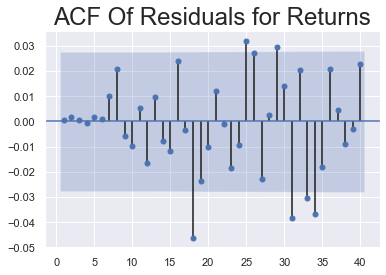

In [55]:
sgt.plot_acf(df.res_ret, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

We can see that the majority of coefficients fall within the blue region, this suggests they are not significantly different from zero which fits the characteristics of **White-Noise**.

However the few points that fall outside the blue area lead us to believe that there is an even better predictor.

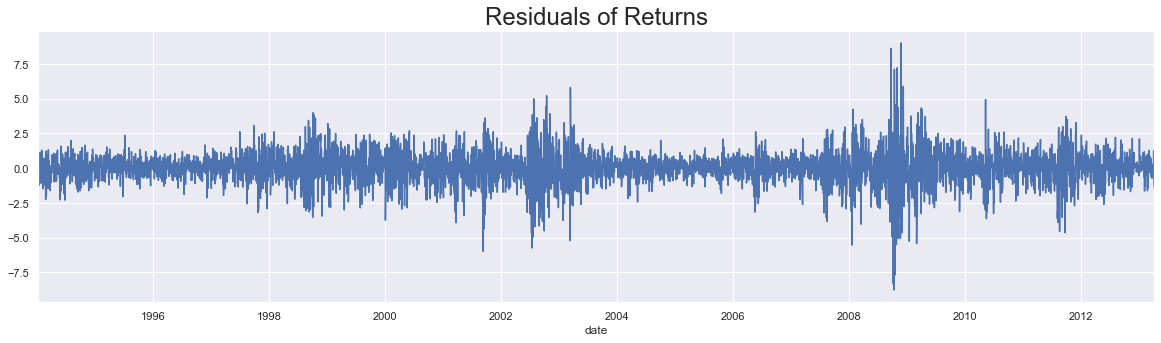

In [56]:
df.res_ret.plot(figsize=(20,5))
plt.title("Residuals of Returns", size=24)
plt.show()